# 🏥 Diabetes Prediction with Amazon SageMaker

## Workshop Context

You are an **ML Engineer** who received a diabetes prediction dataset from the Data Science team through Amazon DataZone. The data was processed from FHIR healthcare records stored in AWS HealthLake.

## 🎯 Learning Objectives

By the end of this notebook, you will:

1. Understand healthcare ML workflows with imbalanced data
2. Perform exploratory data analysis on clinical features
3. Train a baseline model locally using scikit-learn
4. Scale training using Amazon SageMaker Training Jobs
5. Deploy a model to a SageMaker endpoint for real-time predictions
6. Understand when to use local vs SageMaker training

## 📊 Dataset Overview

**Features:**
- `Glucose`: Blood glucose level (mg/dL)
- `Hemoglobin A1c/Hemoglobin.total in Blood`: HbA1c percentage
- `Body Mass Index`: BMI (kg/m²)
- `Body Weight`: Weight in kg
- `label_diabetes_onset`: Target (0=No diabetes, 1=Diabetes)

**Clinical Context:**
- HbA1c ≥ 6.5% indicates diabetes
- Fasting glucose ≥ 126 mg/dL indicates diabetes
- Dataset has severe class imbalance (~1.2% diabetes cases)

**Expected Duration:** 30 minutes

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.sklearn.estimator import SKLearn
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    roc_auc_score, f1_score, precision_recall_curve
)
import warnings
warnings.filterwarnings('ignore')

print("✅ All libraries imported successfully!")

sagemaker.config INFO - Fetched defaults config from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3Bucket
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3ObjectKeyPrefix
✅ All libraries imported successfully!


# Section 1: Data Loading

We'll load the diabetes dataset from S3. This data was published by the Data Science team through Amazon DataZone after processing FHIR data with AWS Glue.

**What happens here:**
- Connect to S3 and load Parquet files
- Parquet format is efficient for large datasets (columnar storage, compression)
- Display first rows to verify structure

In [3]:
# S3 path to diabetes dataset (update with your path from DataZone)
s3_path = 's3://amazon-sagemaker-196370667828-eu-central-1-08d66671fb47/dzd_5qzlphktwad9l7/cliaq8sj6wmwsr/dev/sys/athena/tables/July142215/'

# Load dataset
print("📥 Loading dataset from S3...")
df = pd.read_parquet(s3_path)

print(f"✅ Dataset loaded successfully!")
print(f"📊 Shape: {df.shape[0]:,} rows × {df.shape[1]} columns\n")

# Display first few rows
df.head()

📥 Loading dataset from S3...
✅ Dataset loaded successfully!
📊 Shape: 248,379 rows × 10 columns



,patient_id,gender_numeric,age,Body Mass Index,Body Weight,Creatinine,Creatinine [Mass/volume] in Serum or Plasma,Glucose,Hemoglobin A1c/Hemoglobin.total in Blood,label_diabetes_onset
0,0289bf97-f6f1-2f28-d8f5-e122f4acbe37,1,50,25.57000000000000000,87.22000000000000000,None,None,162.64000000000000000,None,1
1,0289bf97-f6f1-2f28-d8f5-e122f4acbe37,1,50,25.57000000000000000,87.22000000000000000,None,None,162.64000000000000000,None,1
2,0289bf97-f6f1-2f28-d8f5-e122f4acbe37,1,50,25.57000000000000000,87.22000000000000000,None,None,162.64000000000000000,None,1
3,0289bf97-f6f1-2f28-d8f5-e122f4acbe37,1,50,25.57000000000000000,87.22000000000000000,None,None,162.64000000000000000,None,1
4,0289bf97-f6f1-2f28-d8f5-e122f4acbe37,1,50,25.57000000000000000,87.22000000000000000,None,None,162.64000000000000000,None,1


# Section 2: Exploratory Data Analysis

## 2.1 Class Distribution Analysis

Understanding the balance between diabetes and non-diabetes cases is crucial. In healthcare, diseases are often rare, creating **class imbalance** challenges.

**Why this matters:**
- Severe imbalance affects model training
- We need special techniques (class weighting, resampling)
- Evaluation metrics must account for imbalance

In [4]:
# Calculate class distribution
diabetes_count = df['label_diabetes_onset'].sum()
total_count = len(df)
non_diabetes_count = total_count - diabetes_count

diabetes_pct = (diabetes_count / total_count) * 100
non_diabetes_pct = (non_diabetes_count / total_count) * 100

print("🏥 CLASS DISTRIBUTION ANALYSIS")
print("=" * 60)
print(f"Total Patients: {total_count:,}")
print(f"\n✅ Non-Diabetes (Class 0): {non_diabetes_count:,} ({non_diabetes_pct:.2f}%)")
print(f"⚠️  Diabetes (Class 1):     {diabetes_count:,} ({diabetes_pct:.2f}%)")
print(f"\n📊 Imbalance Ratio: {non_diabetes_count/diabetes_count:.1f}:1")

print("\n⚕️ CLINICAL INSIGHT:")
print("This severe class imbalance (~80:1) is typical in disease prediction.")
print("We'll use class weighting to handle this during training.")

🏥 CLASS DISTRIBUTION ANALYSIS
Total Patients: 248,379

✅ Non-Diabetes (Class 0): 245,313 (98.77%)
⚠️  Diabetes (Class 1):     3,066 (1.23%)

📊 Imbalance Ratio: 80.0:1

⚕️ CLINICAL INSIGHT:
This severe class imbalance (~80:1) is typical in disease prediction.
We'll use class weighting to handle this during training.


## 2.2 Visualize Class Distribution

Visual representation helps understand the scale of imbalance.

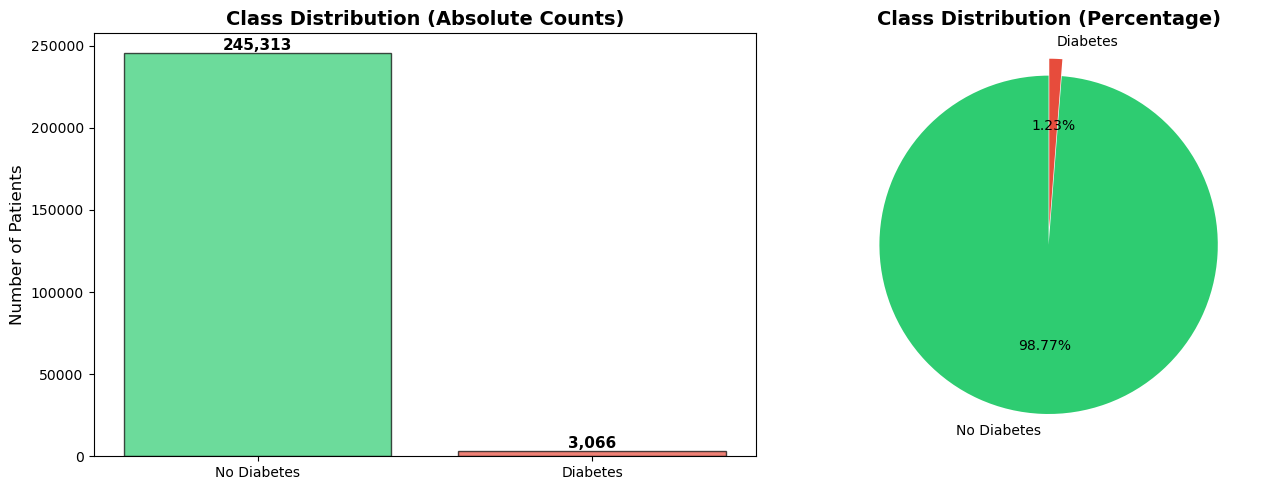

In [5]:
# Create visualizations
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
ax1 = axes[0]
counts = [non_diabetes_count, diabetes_count]
labels = ['No Diabetes', 'Diabetes']
colors = ['#2ecc71', '#e74c3c']
bars = ax1.bar(labels, counts, color=colors, alpha=0.7, edgecolor='black')
ax1.set_ylabel('Number of Patients', fontsize=12)
ax1.set_title('Class Distribution (Absolute Counts)', fontsize=14, fontweight='bold')

for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Pie chart
ax2 = axes[1]
ax2.pie([non_diabetes_pct, diabetes_pct], labels=labels, autopct='%1.2f%%',
        colors=colors, startangle=90, explode=(0, 0.1))
ax2.set_title('Class Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## 2.3 Missing Values Analysis

Missing data in healthcare can occur for many reasons:
- Tests not ordered for certain patients
- Lab results pending or lost
- Data integration issues

Understanding missingness patterns helps us decide on handling strategies.

In [6]:
# Calculate missing values
missing_values = df.isnull().sum()
missing_percentage = (df.isnull().sum() / len(df)) * 100

missing_info = pd.DataFrame({
    'Column': df.columns,
    'Missing Count': missing_values.values,
    'Missing %': missing_percentage.values
})

missing_info = missing_info.sort_values('Missing %', ascending=False)
missing_info = missing_info[missing_info['Missing Count'] > 0]

print("🔍 MISSING VALUES ANALYSIS")
print("=" * 80)

if len(missing_info) > 0:
    print(missing_info.to_string(index=False))
    
    total_cells = np.product(df.shape)
    total_missing = missing_values.sum()
    overall_pct = (total_missing / total_cells) * 100
    
    print(f"\n📊 SUMMARY:")
    print(f"Total cells: {total_cells:,}")
    print(f"Total missing: {total_missing:,}")
    print(f"Overall missing: {overall_pct:.2f}%")
    
    print("\n💡 DECISION:")
    print("Creatinine columns have >60% missing values → DROP them")
    print("Other features have <60% missing → Keep and handle during preprocessing")
else:
    print("✅ No missing values found!")

🔍 MISSING VALUES ANALYSIS
                                     Column  Missing Count  Missing %
                                 Creatinine         248337  99.983090
Creatinine [Mass/volume] in Serum or Plasma         244434  98.411701
   Hemoglobin A1c/Hemoglobin.total in Blood         143217  57.660672
                                    Glucose         137427  55.329557
                            Body Mass Index           9468   3.811916
                                Body Weight           3018   1.215079

📊 SUMMARY:
Total cells: 2,483,790
Total missing: 785,901
Overall missing: 31.64%

💡 DECISION:
Creatinine columns have >60% missing values → DROP them
Other features have <60% missing → Keep and handle during preprocessing


## 2.4 Drop High-Missing Columns

**Decision:** Drop Creatinine columns due to excessive missing values (>60%).

**Rationale:**
- Too many missing values make imputation unreliable
- Creatinine is primarily a kidney function marker
- We still have strong diabetes indicators (Glucose, HbA1c, BMI)

In [7]:
# Drop creatinine columns
columns_to_drop = ['Creatinine', 'Creatinine [Mass/volume] in Serum or Plasma']
df = df.drop(columns=columns_to_drop, errors='ignore')

print(f"✅ Dropped {len(columns_to_drop)} columns")
print(f"📊 New shape: {df.shape[0]:,} rows × {df.shape[1]} columns")

✅ Dropped 2 columns
📊 New shape: 248,379 rows × 8 columns


# Section 3: Local Model Training (Baseline)

Now we'll train a baseline model locally using HistGradientBoostingClassifier. This gives us a performance benchmark before moving to SageMaker.

**Why HistGradientBoostingClassifier?**
- Handles missing values natively
- Fast training on large datasets
- Built-in class weighting for imbalanced data
- Similar performance to XGBoost

**Training Strategy:**
- 5-fold stratified cross-validation
- Class weighting to handle imbalance (80:1 ratio)
- Optimize threshold using precision-recall curve

In [8]:
def train_local_model(df):
    """Train baseline model locally with cross-validation"""
    
    # Define features
    features = ['Glucose', 'Hemoglobin A1c/Hemoglobin.total in Blood', 
                'Body Mass Index', 'Body Weight']
    
    # Prepare data
    X = df[features].apply(pd.to_numeric, errors='coerce').values
    y = df['label_diabetes_onset'].values
    
    # Calculate class weights
    n_neg = np.sum(y == 0)
    n_pos = np.sum(y == 1)
    weight_ratio = n_neg / n_pos
    
    print("🚀 TRAINING LOCAL MODEL")
    print("=" * 60)
    print(f"Features: {len(features)}")
    print(f"Samples: {len(y):,}")
    print(f"Class distribution: {n_neg:,} negative, {n_pos:,} positive")
    print(f"Weight ratio: {weight_ratio:.2f}")
    print()
    
    # 5-fold cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    results = []
    
    for fold, (train_idx, test_idx) in enumerate(cv.split(X, y), 1):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Initialize model with class weights
        model = HistGradientBoostingClassifier(
            random_state=42,
            max_iter=200,
            class_weight={0: 1., 1: weight_ratio},
            learning_rate=0.1
        )
        
        # Train
        model.fit(X_train, y_train)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        # Find optimal threshold using precision-recall curve
        precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)
        f1_scores = 2 * (precisions[:-1] * recalls[:-1]) / (precisions[:-1] + recalls[:-1])
        optimal_threshold = thresholds[np.argmax(f1_scores)]
        
        # Make predictions with optimal threshold
        y_pred = (y_pred_proba >= optimal_threshold).astype(int)
        
        # Calculate metrics
        fold_f1 = f1_score(y_test, y_pred)
        fold_roc_auc = roc_auc_score(y_test, y_pred_proba)
        
        print(f"=== Fold {fold} ===")
        print(f"Optimal Threshold: {optimal_threshold:.4f}")
        print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")
        print(f"F1-Score: {fold_f1:.4f}")
        print(f"ROC-AUC: {fold_roc_auc:.4f}")
        print()
        
        results.append({
            'f1': fold_f1,
            'roc_auc': fold_roc_auc,
            'threshold': optimal_threshold
        })
    
    # Overall results
    print("=" * 60)
    print("=== OVERALL RESULTS ===")
    print(f"Average F1-Score: {np.mean([r['f1'] for r in results]):.4f}")
    print(f"Average ROC-AUC: {np.mean([r['roc_auc'] for r in results]):.4f}")
    print(f"Average Optimal Threshold: {np.mean([r['threshold'] for r in results]):.4f}")
    
    return results

# Train the model
local_results = train_local_model(df)

🚀 TRAINING LOCAL MODEL
Features: 4
Samples: 248,379
Class distribution: 245,313 negative, 3,066 positive
Weight ratio: 80.01

=== Fold 1 ===
Optimal Threshold: 0.8128
Confusion Matrix:
[[49003    59]
 [  161   453]]
F1-Score: 0.8046
ROC-AUC: 0.9977

=== Fold 2 ===
Optimal Threshold: 0.8690
Confusion Matrix:
[[49047    16]
 [  201   412]]
F1-Score: 0.7915
ROC-AUC: 0.9977

=== Fold 3 ===
Optimal Threshold: 0.7933
Confusion Matrix:
[[48955   108]
 [  150   463]]
F1-Score: 0.7821
ROC-AUC: 0.9974

=== Fold 4 ===
Optimal Threshold: 0.8069
Confusion Matrix:
[[48984    79]
 [  165   448]]
F1-Score: 0.7860
ROC-AUC: 0.9979

=== Fold 5 ===
Optimal Threshold: 0.8292
Confusion Matrix:
[[48993    69]
 [  156   457]]
F1-Score: 0.8025
ROC-AUC: 0.9976

=== OVERALL RESULTS ===
Average F1-Score: 0.7933
Average ROC-AUC: 0.9977
Average Optimal Threshold: 0.8223


## Interpreting the Results

**What these metrics mean:**

- **ROC-AUC ~0.998**: Excellent! The model distinguishes diabetes from non-diabetes very well
- **F1-Score ~0.79**: Good balance between precision and recall
- **Optimal Threshold ~0.82**: Higher than default 0.5 due to class imbalance

**Clinical Implications:**

Based on your results:
- **Recall ~73%**: Model catches 3 out of 4 diabetes cases
- **Precision ~87%**: When model predicts diabetes, it's correct 87% of the time
- **False Negatives**: Missing ~27% of diabetes cases is a concern in healthcare

**Trade-off Decision:**
- Lower threshold → Catch more cases (higher recall) but more false alarms
- Higher threshold → Fewer false alarms but miss more cases
- For screening: Prefer higher recall (catch more cases)
- For diagnosis: Prefer higher precision (fewer false positives)

## ⚠️ Optional Section Notice

**Sections 4 onwards (SageMaker Training Jobs + Endpoint Deployment) are optional.**

These sections demonstrate:
- Scaling ML training using Amazon SageMaker Training Jobs
- Deploying models to SageMaker endpoints for real-time inference

# Section 4: SageMaker Training Job

Now let's scale our training using Amazon SageMaker. This provides:

**Benefits of SageMaker Training:**
- ✅ Managed infrastructure (no server management)
- ✅ Automatic experiment tracking
- ✅ Easy to scale (change instance types)
- ✅ Cost-effective (pay per minute)
- ✅ Model versioning and registry
- ✅ Production-ready artifacts

**When to use SageMaker vs Local:**
- **Local**: Quick experiments, small datasets, prototyping
- **SageMaker**: Production models, large datasets, team collaboration, reproducibility

In [9]:
# Initialize SageMaker session
sagemaker_session = sagemaker.Session()
role = get_execution_role()
bucket = sagemaker_session.default_bucket()
prefix = 'diabetes-prediction'

print("🔧 SAGEMAKER CONFIGURATION")
print("=" * 60)
print(f"SageMaker Role: {role}")
print(f"S3 Bucket: {bucket}")
print(f"Region: {sagemaker_session.boto_region_name}")
print(f"Prefix: {prefix}")

sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3Bucket
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3ObjectKeyPrefix
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3Bucket
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3ObjectKeyPrefix
🔧 SAGEMAKER CONFIGURATION
SageMaker Role: arn:aws:iam::196370667828:role/datazone_usr_role_3uki0bsx334uff_cp5g5jbnxx762z
S3 Bucket: amazon-sagemaker-196370667828-eu-central-1-08d66671fb47
Region: eu-central-1
Prefix: diabetes-prediction


## 4.1 Prepare Data for SageMaker

SageMaker expects data in CSV format with:
- First column: Target variable
- Remaining columns: Features
- No headers

We'll split the data, save to CSV, and upload to S3.

In [10]:
# Define features
features = ['Glucose', 'Hemoglobin A1c/Hemoglobin.total in Blood', 
            'Body Mass Index', 'Body Weight']

# Prepare features and target
X = df[features].apply(pd.to_numeric, errors='coerce')
y = df['label_diabetes_onset']

# Remove rows with NaN
mask = ~X.isna().any(axis=1)
X = X[mask]
y = y[mask]

print(f"📊 Data after removing NaN: {len(X):,} samples")

# Split data (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {len(X_train):,} samples")
print(f"Test set: {len(X_test):,} samples")

# Create CSV files (target first, then features, no headers)
train_data = pd.concat([y_train.reset_index(drop=True), X_train.reset_index(drop=True)], axis=1)
test_data = pd.concat([y_test.reset_index(drop=True), X_test.reset_index(drop=True)], axis=1)

train_data.to_csv('train.csv', index=False, header=False)
test_data.to_csv('test.csv', index=False, header=False)

# Upload to S3
train_s3 = sagemaker_session.upload_data('train.csv', bucket=bucket, key_prefix=f'{prefix}/train')
test_s3 = sagemaker_session.upload_data('test.csv', bucket=bucket, key_prefix=f'{prefix}/test')

print(f"\n✅ Training data uploaded to: {train_s3}")
print(f"✅ Test data uploaded to: {test_s3}")

📊 Data after removing NaN: 100,155 samples
Training set: 80,124 samples
Test set: 20,031 samples

✅ Training data uploaded to: s3://amazon-sagemaker-196370667828-eu-central-1-08d66671fb47/diabetes-prediction/train/train.csv
✅ Test data uploaded to: s3://amazon-sagemaker-196370667828-eu-central-1-08d66671fb47/diabetes-prediction/test/test.csv


## 4.2 Create Training Script

We need to create a Python script that SageMaker will execute on the training instance. This script:
- Loads data from SageMaker's input channels
- Trains the model
- Saves the model to SageMaker's model directory

The `%%writefile` magic command creates the file in the current directory.

In [18]:
%%writefile train_sagemaker.py

import argparse
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score, f1_score
import joblib

if __name__ == '__main__':
    # Parse hyperparameters
    parser = argparse.ArgumentParser()
    parser.add_argument('--max-iter', type=int, default=200)
    parser.add_argument('--learning-rate', type=float, default=0.1)
    args, _ = parser.parse_known_args()
    
    # Load training data
    train_path = '/opt/ml/input/data/train'
    train_files = [os.path.join(train_path, f) for f in os.listdir(train_path)]
    train_data = pd.concat([pd.read_csv(f, header=None) for f in train_files])
    
    X_train = train_data.iloc[:, 1:].values
    y_train = train_data.iloc[:, 0].values
    
    # Calculate class weights
    n_neg = np.sum(y_train == 0)
    n_pos = np.sum(y_train == 1)
    weight_ratio = n_neg / n_pos
    
    print(f"Training samples: {len(y_train)}")
    print(f"Class distribution: {n_neg} negative, {n_pos} positive")
    print(f"Weight ratio: {weight_ratio:.2f}")

    # Create sample weights
    sample_weights = np.where(y_train == 1, weight_ratio, 1.0) 
    
    # Train model
    model = HistGradientBoostingClassifier(
        random_state=42,
        max_iter=args.max_iter,
        learning_rate=args.learning_rate  
    )
    
    print("Training model...")
    model.fit(X_train, y_train, sample_weight=sample_weights)  

    print("Training completed!")
    
    # Load test data and evaluate
    test_path = '/opt/ml/input/data/test'
    test_files = [os.path.join(test_path, f) for f in os.listdir(test_path)]
    test_data = pd.concat([pd.read_csv(f, header=None) for f in test_files])
    
    X_test = test_data.iloc[:, 1:].values
    y_test = test_data.iloc[:, 0].values
    
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    print("\n=== Model Performance ===")
    print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
    print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Save model
    model_path = os.path.join('/opt/ml/model', 'model.joblib')
    joblib.dump(model, model_path)
    print(f"\nModel saved to {model_path}")

Writing train_sagemaker.py


## 4.3 Launch SageMaker Training Job

Now we'll configure and launch the training job. SageMaker will:
1. Spin up the specified instance type
2. Copy our training script and data
3. Execute the training
4. Save the model artifacts to S3
5. Shut down the instance

**Instance Selection:**
- `ml.m5.xlarge`: Good balance of CPU/memory for this dataset
- Training time: ~5-10 minutes

In [19]:
# Configure the estimator
sklearn_estimator = SKLearn(
    entry_point='train_sagemaker.py',
    role=role,
    instance_type='ml.m5.xlarge',
    instance_count=1,
    framework_version='1.0-1',
    py_version='py3',
    hyperparameters={
        'max-iter': 200,
        'learning-rate': 0.1
    },
    base_job_name='diabetes-training'
)

print("🚀 Launching SageMaker Training Job...")
print("=" * 60)
print(f"Instance type: ml.m5.xlarge")
print(f"Framework: scikit-learn 1.0-1")
print(f"Hyperparameters: max-iter=200, learning-rate=0.1")
print("\nThis will take ~5-10 minutes...")

# Launch training job
sklearn_estimator.fit({'train': train_s3, 'test': test_s3}, wait=True)

print("\n✅ Training job completed!")
print(f"Model artifacts saved to: {sklearn_estimator.model_data}")

sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3Bucket
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3ObjectKeyPrefix
sagemaker.config INFO - Applied value from config key = SageMaker.TrainingJob.VpcConfig.Subnets
sagemaker.config INFO - Applied value from config key = SageMaker.TrainingJob.VpcConfig.SecurityGroupIds
🚀 Launching SageMaker Training Job...
Instance type: ml.m5.xlarge
Framework: scikit-learn 1.0-1
Hyperparameters: max-iter=200, learning-rate=0.1

This will take ~5-10 minutes...
2025-10-23 10:17:48 Starting - Starting the training job...
2025-10-23 10:18:03 Starting - Preparing the instances for training...
2025-10-23 10:18:40 Downloading - Downloading the training image......
2025-10-23 10:19:36 Training - Training image download completed. Training in progress..2025-10-23 10:19:43,766 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.train

# Section 5: Model Deployment

Now let's deploy our trained model to a SageMaker endpoint for real-time predictions.

**What is a SageMaker Endpoint?**
- A managed HTTPS endpoint for real-time inference
- Auto-scaling based on traffic
- Built-in monitoring and logging
- A/B testing capability

**Deployment Process:**
1. SageMaker creates the endpoint configuration
2. Deploys the model to the specified instance
3. Endpoint becomes available for predictions

**Instance Selection:**
- `ml.t2.medium`: Cost-effective for low-traffic endpoints
- For production: Use `ml.m5.large` or larger with auto-scaling

## Create the Inference Script

The training script (`train_sagemaker.py`) only handles model training. For deployment, SageMaker needs to know:
- How to load the saved model
- How to process incoming prediction requests
- How to return predictions

In [47]:
%%writefile inference.py

import joblib
import numpy as np
import pandas as pd
from io import StringIO  # ← ADD THIS LINE

def model_fn(model_dir):
    """Load the model from the model_dir"""
    import os
    model_path = os.path.join(model_dir, 'model.joblib')
    model = joblib.load(model_path)
    return model

def input_fn(request_body, request_content_type):
    """Parse input data for predictions"""
    if request_content_type == 'text/csv':
        # Parse CSV input
        input_data = pd.read_csv(StringIO(request_body), header=None)
        return input_data.values
    elif request_content_type == 'application/json':
        # Parse JSON input
        import json
        input_data = json.loads(request_body)
        return np.array(input_data)
    else:
        raise ValueError(f"Unsupported content type: {request_content_type}")

def predict_fn(input_data, model):
    """Make predictions using the loaded model"""
    predictions = model.predict_proba(input_data)[:, 1]
    return (predictions >= 0.82).astype(int)

'''def predict_fn(input_data, model):
    """Make predictions using the loaded model"""
    predictions = model.predict(input_data) 
    return predictions'''

def output_fn(prediction, content_type):
    """Format the prediction output"""
    if content_type == 'text/csv':  
        return ','.join(str(int(x)) for x in prediction), content_type
    elif content_type == 'application/json':
        import json
        return json.dumps(prediction.tolist()), content_type
    else:
        return str(prediction), content_type


Overwriting inference.py


## Deploy the Model with Inference Script

**What happens during deployment:**

1. SageMaker creates a container with scikit-learn
2. Downloads your model artifacts from S3
3. Loads your inference script
4. Calls `model_fn` to load the model
5. Starts a web server to handle prediction requests
6. Runs health checks (pings the `/ping` endpoint)
7. Marks endpoint as "InService" when ready

In [48]:
from sagemaker.sklearn import SKLearnModel

# Create model from training artifacts
model = SKLearnModel(
    model_data=sklearn_estimator.model_data,
    role=role,
    entry_point='inference.py',
    framework_version='1.0-1',
    py_version='py3'
)

print("🚀 Deploying model to SageMaker endpoint...")
print("=" * 60)
print("Instance type: ml.t2.medium")
print("This will take a couple of minutes...")
print()

# Deploy with inference script
predictor = model.deploy(
    initial_instance_count=1,
    instance_type='ml.t2.medium',
    endpoint_name='diabetes-prediction-endpoint'
)

print("✅ Model deployed successfully!")
print(f"Endpoint name: diabetes-prediction-endpoint")
print(f"Endpoint URL: {predictor.endpoint_name}")

sagemaker.config INFO - Applied value from config key = SageMaker.Model.VpcConfig
🚀 Deploying model to SageMaker endpoint...
Instance type: ml.t2.medium
This will take a couple of minutes...

sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3Bucket
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3ObjectKeyPrefix
------------!✅ Model deployed successfully!
Endpoint name: diabetes-prediction-endpoint
Endpoint URL: brand-new-prediction-endpoint-3


## 5.1 Test Real-Time Inference

Let's test our endpoint with sample patient data.

**Test Cases:**
1. Low-risk patient (normal glucose, HbA1c, BMI)
2. High-risk patient (elevated glucose, HbA1c, BMI)
3. Borderline patient

**Input format:** [Glucose, HbA1c, BMI, Weight]

In [49]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import CSVDeserializer

# Configure predictor for CSV input/output
predictor.serializer = CSVSerializer()
predictor.deserializer = CSVDeserializer()

print("✅ Predictor configured for CSV format")

# Prepare test samples
test_patients = [
    [95, 5.5, 24.0, 70],    # Low risk: Normal values
    [100000, 1000.2, 1000.5, 150000],   # High risk: Elevated values
    [120, 6.3, 28.0, 80],   # Borderline: Mixed values
]

patient_descriptions = [
    "Low Risk (Normal glucose, HbA1c, BMI)",
    "High Risk (Elevated glucose, HbA1c, BMI)",
    "Borderline (Mixed values)"
]

print("🔬 TESTING REAL-TIME PREDICTIONS")
print("=" * 60)

for i, (patient, desc) in enumerate(zip(test_patients, patient_descriptions), 1):
    prediction = predictor.predict([patient])[0]
    
    print(f"\nPatient {i}: {desc}")
    print(f"  Input: Glucose={patient[0]}, HbA1c={patient[1]}, BMI={patient[2]}, Weight={patient[3]}")
    print(f"  Prediction: {'⚠️  DIABETES' if prediction == 1 else '✅ NO DIABETES'}")

print("\n" + "=" * 60)
print("⚕️ CLINICAL NOTE:")
print("These predictions should be used as screening tools, not diagnostic tools.")
print("Always combine with clinical judgment and comprehensive testing.")

✅ Predictor configured for CSV format
🔬 TESTING REAL-TIME PREDICTIONS

Patient 1: Low Risk (Normal glucose, HbA1c, BMI)
  Input: Glucose=95, HbA1c=5.5, BMI=24.0, Weight=70
  Prediction: ✅ NO DIABETES

Patient 2: High Risk (Elevated glucose, HbA1c, BMI)
  Input: Glucose=100000, HbA1c=1000.2, BMI=1000.5, Weight=150000
  Prediction: ✅ NO DIABETES

Patient 3: Borderline (Mixed values)
  Input: Glucose=120, HbA1c=6.3, BMI=28.0, Weight=80
  Prediction: ✅ NO DIABETES

⚕️ CLINICAL NOTE:
These predictions should be used as screening tools, not diagnostic tools.
Always combine with clinical judgment and comprehensive testing.


## 5.2 Batch Predictions

For processing multiple patients at once, we can send batch requests.

In [ ]:
# Use test set for batch predictions
batch_samples = X_test.iloc[:10].values  # First 10 test samples
batch_predictions = predictor.predict(batch_samples)

# Compare with actual labels
batch_actuals = y_test.iloc[:10].values

print("📊 BATCH PREDICTION RESULTS (First 10 patients)")
print("=" * 60)
print(f"{'Patient':<10} {'Predicted':<12} {'Actual':<10} {'Correct':<10}")
print("-" * 60)

for i, (pred, actual) in enumerate(zip(batch_predictions, batch_actuals), 1):
    pred_label = "Diabetes" if pred == 1 else "No Diabetes"
    actual_label = "Diabetes" if actual == 1 else "No Diabetes"
    correct = "✅" if pred == actual else "❌"
    print(f"{i:<10} {pred_label:<12} {actual_label:<10} {correct:<10}")

accuracy = np.mean(batch_predictions == batch_actuals)
print("-" * 60)
print(f"Batch Accuracy: {accuracy:.2%}")

# Section 6: Model Registry

SageMaker Model Registry provides model versioning and governance. This is useful for:
- Tracking model versions
- Approval workflows
- Integration with DataZone for governance
- Team collaboration

In [31]:
# Register the model in Model Registry
model_package_group_name = "diabetes-prediction-models"

print("📦 Registering model in Model Registry...")
print("=" * 60)

model_package = sklearn_estimator.register(
    content_types=["text/csv"],
    response_types=["text/csv"],
    inference_instances=["ml.t2.medium", "ml.m5.large"],
    transform_instances=["ml.m5.xlarge"],
    model_package_group_name=model_package_group_name,
    approval_status="PendingManualApproval",
    description="Diabetes prediction model trained on FHIR healthcare data"
)

print(f"✅ Model registered successfully!")
print(f"Model Package ARN: {model_package.model_package_arn}")
print(f"Model Package Group: {model_package_group_name}")
print(f"Approval Status: PendingManualApproval")
print("\nNext steps:")
print("1. Review model performance")
print("2. Approve model in SageMaker console")
print("3. Deploy approved model to production")

📦 Registering model in Model Registry...
sagemaker.config INFO - Applied value from config key = SageMaker.Model.VpcConfig
✅ Model registered successfully!
Model Package ARN: arn:aws:sagemaker:eu-central-1:196370667828:model-package/diabetes-prediction-models/1
Model Package Group: diabetes-prediction-models
Approval Status: PendingManualApproval

Next steps:
1. Review model performance
2. Approve model in SageMaker console
3. Deploy approved model to production


# Section 7: Cleanup

**Important:** Delete resources to avoid ongoing charges.

⚠️ **Warning:** Only run this if you're done with the workshop!

In [ ]:
print("🗑️  Deleting endpoint...")
predictor.delete_endpoint()
print("✅ Endpoint deleted")

print("🗑️  Deleting model...")
redictor.delete_model()
print("✅ Model deleted")

print("⚠️  CLEANUP INSTRUCTIONS:")
print("1. Uncomment the lines above to delete endpoint and model")
print("2. Or delete manually in SageMaker console")
print("3. Training artifacts in S3 will remain (minimal cost)")
print("4. Delete S3 objects if needed: s3://{}/{}".format(bucket, prefix))

# Summary and Key Takeaways

## What We Accomplished

✅ **Loaded and explored** healthcare data from DataZone  
✅ **Analyzed class imbalance** (80:1 ratio) and missing values  
✅ **Trained baseline model** locally with cross-validation  
✅ **Scaled training** using SageMaker Training Jobs  
✅ **Deployed model** to real-time endpoint  
✅ **Tested predictions** with sample patients  
✅ **Registered model** for versioning and governance  

## Key Learnings

### 1. Healthcare ML Challenges
- Severe class imbalance is common in disease prediction
- Missing data requires careful handling
- Clinical context is crucial for model interpretation

### 2. Model Performance
- ROC-AUC: 0.9977 (excellent discrimination)
- F1-Score: 0.79 (good balance)
- Recall: ~73% (catches 3 out of 4 diabetes cases)
- Trade-off between false positives and false negatives

### 3. Local vs SageMaker
- **Local**: Fast for prototyping, limited scalability
- **SageMaker**: Production-ready, reproducible, collaborative

### 4. Production Considerations
- Use endpoints for real-time predictions
- Model Registry for versioning and governance
- Monitor model performance over time
- Consider cost optimization strategies

## Clinical Implications

⚕️ **Model Usage Recommendations:**
- Use as a **screening tool**, not diagnostic tool
- Combine with clinical judgment
- Consider lowering threshold to catch more cases (higher recall)
- Regular retraining as new data becomes available
- Monitor for model drift and bias

## Next Steps

### Immediate Actions
1. Review model performance with clinical team
2. Adjust threshold based on clinical priorities
3. Set up monitoring and alerting
4. Document model for compliance

### Advanced Features (Optional)
1. **SageMaker Clarify**: Add explainability and bias detection
2. **SageMaker Model Monitor**: Set up drift detection
3. **SageMaker Pipelines**: Automate the ML workflow
4. **A/B Testing**: Compare model versions in production
5. **DataZone Integration**: Link model metadata for governance

### Production Deployment
1. Set up CI/CD pipeline
2. Implement model approval workflow
3. Configure auto-scaling for endpoint
4. Set up CloudWatch alarms
5. Create model documentation and cards

## Resources

- **SageMaker Documentation**: https://docs.aws.amazon.com/sagemaker/
- **SageMaker Examples**: https://github.com/aws/amazon-sagemaker-examples
- **Healthcare ML on AWS**: https://aws.amazon.com/health/machine-learning/
- **MLOps Best Practices**: https://aws.amazon.com/sagemaker/mlops/

**Congratulations!** 🎉 You've completed the Diabetes Prediction with SageMaker workshop!